# AUTOENCODIX PACKAGE HANDBOOK
This notebook demonstrates the usage of the autoencodix package.
For now it serves as an internal guideline with the goal to:
- test the package from a user perspective
- serve as a first draft of user documentation
- serve a developer guideline 
  - developer guide will be derrived from this notebook

## 00 Generate mock data
When  development proceeds this section should be used to  show how to use different datatypes
for now we only use a mock numpy array

In [ ]:
import numpy as np

sample_data = np.random.rand(100, 10)
sample_data.shape

(100, 10)

## 01 General Pipeline Usage

In [2]:
# imports
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1036f1750>>
Traceback (most recent call last):
  File "/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
#### --------------------------------------------
# TODO user prepares data or config
### INITIALIZATION ### --------------------------
# Use Vanillix Pipeline interface
# needs to be initialized with data
# data should be a numpy array, pandas dataframe or AnnData object
# possible to pass a custom Config object
van = acx.Vanillix(data=sample_data)
# ------------------------------------------------
### DATA PROCESSING ### --------------------------
# job of old make data
# populates self._features attrbute with torch tensor
# populates self._datasets attribute with torch dataset
# (important for training with dataloader)
# possible to pass a custom Config object, or keyword arguments
van.preprocess()
# ------------------------------------------------
### MODEL TRAINING ### --------------------------
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (model, losses, etc)
van.fit()
# ------------------------------------------------
### PREDICTION ### -------------------------------
# job of old make predict
# if no data is passed, used the test split from preprocessing
# otherwise, uses the data passed, and preprocesses it
# updates self.result attribute with predictions (latent space, reconstructions, etc)
van.predict()
# ------------------------------------------------
### EVALUATION ### -------------------------------
# job of old make ml_task
# populates self.result attribute with ml task results
van.evaluate()  # not implemented yet
# ------------------------------------------------
### VISUALIZATION ### ---------------------------
# job of old make visualize
# populates self.result attribute with visualizations
van.visualize()
# show visualizations for notebook use
van.show_result()
# --------------------------
# --------------------------
# run all steps in the pipeline
result_object = van.run()

cpu not relevant here
batch: 0
model_outputs.reconstruction: torch.Size([32, 10])
batch: 1
model_outputs.reconstruction: torch.Size([32, 10])
batch: 2
model_outputs.reconstruction: torch.Size([6, 10])
Epoch: 0, Loss: 2.3556206822395325
output.reconstruction: torch.Size([32, 10])
output.reconstruction: torch.Size([32, 10])
output.reconstruction: torch.Size([6, 10])
output.reconstruction: torch.Size([10, 10])
batch: 0
model_outputs.reconstruction: torch.Size([32, 10])
batch: 1
model_outputs.reconstruction: torch.Size([32, 10])
batch: 2
model_outputs.reconstruction: torch.Size([6, 10])
Epoch: 1, Loss: 2.308934450149536
output.reconstruction: torch.Size([32, 10])
output.reconstruction: torch.Size([32, 10])
output.reconstruction: torch.Size([6, 10])
output.reconstruction: torch.Size([10, 10])
batch: 0
model_outputs.reconstruction: torch.Size([32, 10])
batch: 1
model_outputs.reconstruction: torch.Size([32, 10])
batch: 2
model_outputs.reconstruction: torch.Size([6, 10])
Epoch: 2, Loss: 2.2133

In [ ]:
recons = result_object.reconstructions.get(split="train", epoch=2)
recons_val = result_object.reconstructions.get(split="valid", epoch=2)
recons_test = result_object.reconstructions.get(split="test", epoch=-1)
print(recons.shape, recons_val.shape, recons_test.shape)

(70, 10) (10, 10) (20, 10)


In [ ]:
latents = result_object.latentspaces.get(split="train", epoch=2)
latents_val = result_object.latentspaces.get(split="valid", epoch=2)
latents_test = result_object.latentspaces.get(split="test", epoch=-1)
print(latents.shape, latents_val.shape, latents_test.shape)

(70, 16) (10, 16) (20, 16)


#### Using a custom train, test, valid split
When you pass the data to the pipeline, autoencodix, internally splits the data for you based on the train,test, valid ratios provided in the config (defaults are 70%/10%/20% train/valid/test).
You can either pass custom ratios (see next section) or provide the indices directly as shown below

In [ ]:
sample_data = np.random.rand(100, 10)
custom_train_indices = np.arange(75)  # we won't allow overlap between splits
custom_valid_indices = np.arange(75, 80)
custom_test_indices = np.arange(80, 100)

# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}
van = acx.Vanillix(data=sample_data, custom_splits=custom_split)
van.preprocess()
van.fit(epochs=3)

cpu not relevant here


Epoch: 0, Loss: 2.367237627506256
Epoch: 1, Loss: 2.1364158391952515
Epoch: 2, Loss: 2.140314042568207


It is possible to pass empty splits, but depending on how you'll use the autoencodix pipeline, this will throw an error at some point. So it is possible to call `fit` with only training data, but if you want to call `predict` and don't provide new data, this won't work without a data in the test split

#### Using predict with new data
The standard case is to train the model with the train data and then predict with the test split.
However, it is possible to pass new data to the predict method to perform inference on this data with the already trained model

In [ ]:
new_unseen_data = np.random.rand(10, 10)
van.predict(data=new_unseen_data)


Invalid parameters: data
Valid parameters are: config


#### Examining the result of the pipeline
Each step in the pipeline writes its results in the result object of the Vanillix instance.
In this section we explore how to access and make sense of the results.

In [ ]:
result = van.result
print(result)

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
preprocessed_data: Tensor of shape (100, 10)
model: _FabricModule
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x1053f1e70>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x10626cd90>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x10626ce20>)


##### TrainingDynamics object in result
The training dynamics object has the followinf form:
<epoch><split><data>
So if you want to access the train loss for the 5th epoch, you would:
`result.lossss.get(epoch=5, split="train")`

In [ ]:
loss_train_ep2 = result.losses.get(epoch=2, split="train")
print(loss_train_ep2)
valid_loss = result.losses.get(split="valid")
print(valid_loss)
print(result.losses.get())

0.7134380141894022
[0.27492604 0.24243712 0.23720634]
{0: {'train': array(0.78907921), 'valid': array(0.27492604)}, 1: {'train': array(0.71213861), 'valid': array(0.24243712)}, 2: {'train': array(0.71343801), 'valid': array(0.23720634)}}


Note: this schema works for every TrainingDynamics instance in the results object.

## 02 Pipeline usage with custom parameters
Here we show how to customize the above shown pipeline with a user config or with keyword arguments.
In future iterations we want to allow to read a config from a file, this will be also demonstrated here.

In [ ]:
# Use Vanillix Pipeline interface
# needs to be initialized with data
# data should be a numpy array, pandas dataframe or AnnData object
# possible to pass a custom Config object
van = acx.Vanillix(data=sample_data)
# job of old make data
# populates self._features attrbute with torch tensor
# populates self._datasets attribute with torch dataset
# (important for training with dataloader)
# possible to pass a custom Config object, or keyword arguments
van.preprocess()
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (losses, etc)
# van.fit()
""" 
Each step can be run separately, with custom parameters, these parameters
can be passed as keyword arguments, or as a Config object
"""
van.fit(learning_rate=0.01, batch_size=32, epochs=5)  # or like this:
my_config = DefaultConfig(learning_rate=130.0, batch_size=32, epochs=5)
van.fit(config=my_config)  # config has to be an keyword argument


cpu not relevant here
Epoch: 0, Loss: 1.9614873230457306
Epoch: 1, Loss: 1.382771223783493
Epoch: 2, Loss: 0.977891355752945
Epoch: 3, Loss: 0.6883653551340103
Epoch: 4, Loss: 0.5179779827594757
cpu not relevant here
Epoch: 0, Loss: 8780462592.772186
Epoch: 1, Loss: 1348435297.7003174
Epoch: 2, Loss: 5917.90837097168
Epoch: 3, Loss: 10487.504081726074
Epoch: 4, Loss: 3092.8131675720215


#### 02.1  How to relevant keyword arguments for pipeline methods
It can be hard to know what keyword arguments are valid for each step,
so we show:
- how to get a list of allowed keyword arguments
- what happens if you pass non-allowed keyword arguments

In [ ]:
# for each config method, we can call a valid_params method
van = acx.Vanillix(data=sample_data)
fit_params = (
    van.fit.valid_params
)  # returns a set of keyword arguments that are actually used in the fit method

import pprint

pprint.pprint(fit_params)

{'batch_size',
 'checkpoint_interval',
 'config',
 'device',
 'epochs',
 'global_seed',
 'gpu_strategy',
 'learning_rate',
 'n_gpus',
 'n_workers',
 'reconstruction_loss',
 'reproducible',
 'weight_decay'}


To get even more verbose info about the keyword args, you can run the following code.

In [ ]:
# when you want to have more info about the params, you can get type hints from the config object
my_config = DefaultConfig()
conig_values = my_config.get_params()
my_config.print_schema(filter_params=fit_params)

Valid Keyword Arguments:
--------------------------------------------------

learning_rate:
  Type: <class 'float'>
  Default: 0.001
  Description: Learning rate for optimization

batch_size:
  Type: <class 'int'>
  Default: 32
  Description: Number of samples per batch

epochs:
  Type: <class 'int'>
  Default: 3
  Description: Number of training epochs

weight_decay:
  Type: <class 'float'>
  Default: 0.01
  Description: L2 regularization factor

reconstruction_loss:
  Type: typing.Literal['mse', 'bce']
  Default: mse
  Description: Type of reconstruction loss

device:
  Type: typing.Literal['cpu', 'cuda', 'gpu', 'tpu', 'mps', 'auto']
  Default: auto
  Description: Device to use

n_gpus:
  Type: <class 'int'>
  Default: 1
  Description: Number of GPUs to use

n_workers:
  Type: <class 'int'>
  Default: 2
  Description: Number of data loading workers

checkpoint_interval:
  Type: <class 'int'>
  Default: 1
  Description: Interval for saving checkpoints

gpu_strategy:
  Type: typing.Lit

If you pass not supported parameters you get a warning

In [ ]:
# if you use an unsupported keyword argument, you will get a warning
# as you see the default value from the DefaultConfig is not overwritten and the training will take 100 epochs (not 10)
van.preprocess()
van.fit(epochds=10)


Invalid parameters: epochds
Valid parameters are: batch_size, checkpoint_interval, config, device, epochs, global_seed, gpu_strategy, learning_rate, n_gpus, n_workers, reconstruction_loss, reproducible, weight_decay
cpu not relevant here
Epoch: 0, Loss: 2.2837421894073486
Epoch: 1, Loss: 2.2954598665237427
Epoch: 2, Loss: 2.3972206711769104


#### 02.2 How to get information about the default config parameters

In [ ]:
# if you want to see what config parameters are used in the default config you can do it like:
default_config = DefaultConfig()
default_config.print_schema()



DefaultConfig Configuration Parameters:
--------------------------------------------------

latent_dim:
  Type: <class 'int'>
  Default: 16
  Description: Dimension of the latent space

n_layers:
  Type: <class 'int'>
  Default: 3
  Description: Number of layers in encoder/decoder

enc_factor:
  Type: <class 'int'>
  Default: 4
  Description: Scaling factor for encoder dimensions

input_dim:
  Type: <class 'int'>
  Default: 10000
  Description: Input dimension

drop_p:
  Type: <class 'float'>
  Default: 0.1
  Description: Dropout probability

learning_rate:
  Type: <class 'float'>
  Default: 0.001
  Description: Learning rate for optimization

batch_size:
  Type: <class 'int'>
  Default: 32
  Description: Number of samples per batch

epochs:
  Type: <class 'int'>
  Default: 3
  Description: Number of training epochs

weight_decay:
  Type: <class 'float'>
  Default: 0.01
  Description: L2 regularization factor

reconstruction_loss:
  Type: typing.Literal['mse', 'bce']
  Default: mse
  

### 02.3 Documentation Config class
You can update the config with your own values by:
- passing arguments as:
    - dict
    - single arguments
- passing a file (TODO)

In [ ]:
from autoencodix.utils.default_config import DefaultConfig

# METHOD 1: override the default config with a dictionary
my_args = {"learning_rate": 0.0234, "batch_size": 13, "epochs": 12}
my_config = DefaultConfig(**my_args)
# METHOD 2: override signle parameters
my_new_conig = DefaultConfig(latent_dim=23, n_gpus=13)

# METHOD 3: from a file: TODO


## 03 Use the Varix model
Now we show how easy it is to use a variational autoencoder instead of a vanilla version.

In [7]:
from autoencodix.utils.default_config import DefaultConfig
import autoencodix as acx
import numpy as np

sample_data = np.random.rand(100, 10)
my_config = DefaultConfig(learning_rate=0.001, epochs=3, checkpoint_interval=1)
varix = acx.Varix(data=sample_data, config=my_config)
result = varix.run()

cpu not relevant here
Epoch: 0, Loss: 1.3720149099826813
Epoch: 1, Loss: 1.1976171135902405
Epoch: 2, Loss: 1.221748024225235

Invalid parameters: data
Valid parameters are: config


#### Examine Variational result
Here, we have more info in our results object than in the Vanillix case. We have the learned paramters mu and logvar of the normal distirbution, in addition to the losses and reconstructions. We provide also the sampled latentspaces at each epoch and split.

You can resample new latenspaces (shown in next section)

In [6]:
# we did not train for the test split, so we don't need to pass an epoch
# technically the epoch is -1
mu_test_ep_last = result.latentspaces.get(split="test")
print(mu_test_ep_last.shape)

(1, 20, 16)


#### Different loss types
For our variation autoencoder, the total loss consists of a reconstruction loss and a distribution loss i.e. kl-divergence. To investigate these losses, the result_obj has the attribute `sub_losses`. This is a `LossRegistry` withe the name of the loss as key and the value is of class `TrainingDynamics` and can be accessed as shown for the Vanillix part

In [7]:
sub_losses = result.sub_losses
print(f"keys: {sub_losses.keys()}")
recon_dyn = sub_losses.get(key="recon_loss")
print(recon_dyn.get(split="train"))

keys: dict_keys(['recon_loss', 'var_loss'])
[0.42741003 0.44090185 0.37895077]


#### Sample new latentspaces
You might want to use the trained model and the fitted parameters mu, and logvar to sample latentspaces. Therefore, the Varix pipeline has the additional method `sample_latent_space`

In [6]:
sampled = varix.sample_latent_space()

print(sampled[:5])

tensor([[ 1.4227, -1.1264, -0.5146, -0.6423,  1.3555,  0.1267,  1.1256, -0.8374,
          1.2268, -1.7507,  0.9605, -0.4691,  0.9137, -0.8082, -0.5185, -0.1135],
        [ 0.0871, -0.7650, -0.7087,  1.9782,  0.5053,  0.0163,  0.5845, -0.4165,
          0.2073,  1.6614, -0.8132,  0.6487, -1.5413, -0.4115,  0.0680,  0.1220],
        [ 0.5332,  0.1249,  1.5426,  1.3922,  0.3982,  0.5452,  0.5251, -0.1709,
          0.2392, -0.6901,  0.6993, -2.4067,  0.7687,  0.4694, -1.3835, -1.3028],
        [ 0.4925,  0.2083, -0.3846,  0.7595, -0.3062, -0.2996, -0.4743,  1.3784,
          1.0943, -0.0518, -0.3465, -0.3751,  0.3677,  0.3754, -0.2108, -0.4754],
        [-0.1330,  1.1649,  0.2671,  0.2378, -3.0322, -1.7903, -0.1169,  1.0738,
         -0.9661,  0.0313,  0.2592, -1.3385,  0.7877, -0.0342,  1.4808,  2.4948]],
       device='mps:0')


In [8]:
# you can also select a specific epoch and split to sample from (default is last epoch and test split)
sampled = varix.sample_latent_space(epoch=2, split="valid")
print(sampled[:5])

tensor([[ 0.3581,  0.8946,  2.3437, -1.0793,  1.5991, -0.6819,  1.3511,  0.7896,
         -0.6627,  1.4723,  1.3740, -0.8405, -0.3541, -0.3976,  1.8037, -0.3309],
        [-2.7742,  1.3001, -0.7447, -1.5788, -1.3535,  0.3174, -0.5517,  0.9802,
         -1.0824,  1.4315, -0.8219, -1.6757,  0.4232, -1.0295, -1.2279,  0.2959],
        [-0.5726,  1.2144,  1.3754, -0.1848,  1.2447, -0.2668, -1.7038,  1.4772,
          0.6938,  0.8111,  0.5638, -1.3457,  1.3015, -2.0530, -1.4406, -0.6207],
        [-0.5844,  1.0119,  1.3542,  0.8185,  0.4677,  0.6580, -0.4376, -1.5302,
          0.3264,  0.5532,  1.9664, -1.2441,  1.4664, -1.4824,  1.2571, -1.7927],
        [ 1.2330, -0.1874, -0.8378,  1.5088, -0.8935, -0.0678, -0.0589, -0.2272,
          0.4520, -1.1687,  0.4746,  0.1345, -0.5463, -0.4620,  0.9897, -0.3327]],
       device='mps:0')


In [10]:
# or sample multiple times
for _ in range(5):
    sampled = varix.sample_latent_space()
    print(sampled[:3, :3])

tensor([[ 0.8121, -0.2599, -1.1656],
        [-1.5269,  0.5212, -0.3416],
        [ 1.1872,  1.8373,  0.4524]], device='mps:0')
tensor([[ 2.3787,  0.1305, -0.7975],
        [-0.3502, -0.2842,  1.0856],
        [-2.3673,  1.2124,  1.5476]], device='mps:0')
tensor([[ 0.0609,  2.3645,  0.2055],
        [-0.3573, -1.5928,  0.5545],
        [-2.5494, -0.6906, -0.8733]], device='mps:0')
tensor([[ 0.9513,  1.5320,  1.5767],
        [ 0.4684, -1.0381,  0.9011],
        [-1.0837,  1.9147,  0.4768]], device='mps:0')
tensor([[-0.0046, -1.3439, -0.2800],
        [ 1.0443, -0.2889, -0.1052],
        [ 0.5079,  1.7101,  0.0815]], device='mps:0')


## 04 How to work with custom omics data
In the above steps we showed how to use `Autoencodix` with mock data. Nowe we demonstrate how to use real-world data. We'll cover:
1. combining multi-omics data from bulk sequencing (e.g. mRNA and methylation)
2. combining multi-omics data from single cell sequencing
3. "Translating" between multi-omics data e.g. scRNA <-> scATAC, or bulkmRNA <-> bulkmiRNA
4. Working with image data
5. "translating" between data-modalities
  - one bulk-omics modality to another
  - omics to image an vice versa

### 04.1 Combining mulit-omics data from bulk-sequencing
First we need to prepare our config object. We can (a) directly provide an object in python, or (b) provide an YAML file. We show both

#### YAML config
Assume we have the file in `./config.yaml`.
We can keep the yaml file structure to define our input data like:
```yaml
data_config: # has to be named data_config
  data_info: # has to be named data_infor
   RNA: # name can be chosen by user
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   METHYLATION: # can be chosen by user
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   CLINICAL: # can be chosen by user
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION" # default NUMERIC (as for RNA and METHYLATION)
```
ATTENTION:
If you use `.txt` or `.csv` files, it is best practice to add the `sep` parameter. If none is given, the reader will try to auto-detect the separator, which is error prone.
This would loke like:
```YAML
    RNA:
      ...
      sep: "\t" # for tab, ";" or "," would be also possible (as in pandas)

```

In [1]:
import yaml
from pathlib import Path
from autoencodix.utils.default_config import DefaultConfig
import os

os.chdir("../")
print(os.getcwd())
# this fills the data_config attribute of the DefaultConfig object
# we can also change the default values in the config.yaml file
# or via the DefaultConfig object
config = DefaultConfig.model_validate(yaml.safe_load(Path("config.yaml").read_text()))

/Users/maximilianjoas/development/autoencodix_package


In [2]:
# with custom values
custom_config = DefaultConfig.model_validate(
    {**yaml.safe_load(Path("config.yaml").read_text()), "learning_rate": 0.77}
)

In [3]:
print(config.data_config)
print(config.learning_rate)
print(custom_config.learning_rate)

data_info={'RNA': DataInfo(file_path='data/raw/data_mrna_seq_v2_rsem_formatted.parquet', data_type='NUMERIC', scaling='STANDARD', filtering='VAR', is_single_cell=False, data_object=None, min_cells=None, min_genes=None, translate_direction=None, img_root=None, is_X=None, sep=None, extra_anno_file=None), 'METHYLATION': DataInfo(file_path='data/raw/data_methylation_per_gene_formatted.parquet', data_type='NUMERIC', scaling='STANDARD', filtering='VAR', is_single_cell=False, data_object=None, min_cells=None, min_genes=None, translate_direction=None, img_root=None, is_X=None, sep=None, extra_anno_file=None), 'CLINICAL': DataInfo(file_path='data/raw/data_clinical_formatted.parquet', data_type='ANNOTATION', scaling='STANDARD', filtering='VAR', is_single_cell=False, data_object=None, min_cells=None, min_genes=None, translate_direction=None, img_root=None, is_X=None, sep=None, extra_anno_file=None)} patient_id_column='patient_id' output_h5ad='multiomics.h5ad'
0.001
0.77


#### Create DataConfig in Python
We will only use one way of config creation for the next examples.

In [4]:
from autoencodix.utils.default_config import DataConfig, DataInfo

root_dir = os.path.join("data/raw")
meth_file = "data_methylation_per_gene_formatted.parquet"
mrna_file = "data_mrna_seq_v2_rsem_formatted.parquet"
clin_file = "data_clinical_formatted.parquet"

bulk_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "RNA": DataInfo(file_path=os.path.join(root_dir, mrna_file)),
            "METHYLATION": DataInfo(file_path=os.path.join(root_dir, meth_file)),
            "CLINICAL": DataInfo(
                file_path=os.path.join(root_dir, clin_file), data_type="ANNOTATION"
            ),
        }
    )
)

#### Building the input data
Practically we would be done with the above step. We pass the config to the pipeline as shown multiple times before. For cleared documentation (esepcially for Devs) we show what happens inside the pipeline

In [6]:
from autoencodix.utils._bulkreader import BulkDataReader

reader = BulkDataReader()
common_samples, config = reader.load_and_intersect_bulkdata(config=bulk_config)
print(len(common_samples))

Loading RNA data from data/raw/data_mrna_seq_v2_rsem_formatted.parquet
Loading METHYLATION data from data/raw/data_methylation_per_gene_formatted.parquet
Loading CLINICAL data from data/raw/data_clinical_formatted.parquet
10001


In [7]:
bulk_anndata = reader.build_bulk_anndata(common_samples=common_samples, config=config)
print(bulk_anndata)


AnnData object with n_obs × n_vars = 10001 × 16313
    obs: 'PATIENT_ID', 'ONCOTREE_CODE', 'CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'TUMOR_TYPE', 'GRADE', 'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_SOURCE_SITE_CODE', 'TUMOR_TISSUE_SITE', 'ANEUPLOIDY_SCORE', 'SAMPLE_TYPE', 'MSI_SCORE_MANTIS', 'MSI_SENSOR_SCORE', 'SOMATIC_STATUS', 'TMB_NONSYNONYMOUS', 'TISSUE_SOURCE_SITE', 'SUBTYPE', 'CANCER_TYPE_ACRONYM', 'OTHER_PATIENT_ID', 'AGE', 'SEX', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'AJCC_STAGING_EDITION', 'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH', 'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 'ETHNICITY', 'FORM_COMPLETION_DATE', 'HISTORY_NEOADJUVANT_TRTYN', 'ICD_10', 'ICD_O_3_HISTOLOGY', 'ICD_O_3_SITE', 'INFORMED_CONSENT_VERIFIED', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_T_STAGE', 'PERSON_NEOPLASM_CANCER_STATUS', 'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', 'PRIOR_DX', 'RACE', 'RADIATION_THERAPY', 'WEIGHT', 'IN_PANCAN

##### Explanation of AnnData
The Annotation data is saved in `obs` in the AnnData object. The different omics types are (not typical for single cell, but we use bulk here) in `.obsm`. The `.X` will be populated based on either by the first dataset. Internally we only work with `obs` and `obsm`
The AnnData object will then be passed to the preprocessor and eventually will be transformed to a torch Dataset to use in training.
You can either pass the config with the location of your datafiles to the `Autoencodix` pipeline, or you can create the data yourself and pass the AnnData object

### 04.2 Working with single cell data from different sequencing processes
First we define our config again, then we use the reader object to build the AnnData (this will look more familar for single cell practioners)

We can provide a config yaml like:
```YAML
# config.yaml
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad" # we request h5ad files
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
```

In [ ]:
from autoencodix.utils import DefaultConfig
import yaml
from pathlib import Path

scconfig = DefaultConfig.model_validate(
    yaml.safe_load(Path("scconfig.yaml").read_text())
)

In [10]:
from autoencodix.utils._screader import SingleCellDataReader

reader = SingleCellDataReader()
adata, scconfig = reader.load_and_build_sc_anndata(config=scconfig)

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 45549 × 17425
    obs: 'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'RNA_author_cell_type', 'RNA_age_group', 'RNA_donor_id', 'RNA_nCount_RNA', 'RNA_nFeature_RNA', 'RNA_nCount_ATAC', 'RNA_nFeature_ATAC', 'RNA_TSS_percentile', 'RNA_nucleosome_signal', 'RNA_percent_mt', 'RNA_assay_ontology_term_id', 'RNA_cell_type_ontology_term_id', 'RNA_development_stage_ontology_term_id', 'RNA_disease_ontology_term_id', 'R

### 04.3 Translating between omics data
We only allow bulk to bulk and single-cell to single cell. The config is almost identical to the case before, we only add the direction of the translation like:
```YAML
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad"
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
     translate_direction: "FROM"
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
     translate_direction: "TO"

```

For the bulk case we can keep annotation data without including it in the translation like:
```YAML
# config.yaml
data_config:
  data_info:
   RNA:
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false
     translate_direction: "FROM"
   METHYLATION:
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false
     translate_direction: "TO"
   CLINICAL:
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION"
     # default translate_direction is  NONE, so we don't need to specify it here
```

### 04.4 Working with images
When working with images, we need have two cases:
- pure image, without translating
- translating between omics and images

In the first case we need to provide the folder path of the images. In the second case we need to provide the folder path of the images and an annotation file that maps the metadata for the images to the image filenames. In this file we also need to map the sample_ids of the other data modality to the image filename and metadata. Later we will add support for an unpaired case, where we only provide image metadata without mapping to the other data modality.
The file should look like this:
**important**: this file needs to contain the columns `sample_ids` and `img_paths`
```text
sample_ids	img_paths	METADATA1	METADATA2
TCGA-05-4244-01	0_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4249-01	1_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4250-01	2_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4382-01	3_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4384-01	4_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4389-01	5_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4390-01	6_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4395-01	7_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4396-01	8_label_1.png	Non-Small Cell Lung Cancer	LUAD
```

#### Image only case

In [11]:
from autoencodix.utils.default_config import DataConfig, DataInfo

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(file_path="data/raw/images/tcga_fake", data_type="IMG"),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt", data_type="ANNOTATION"
            ),
        }
    )
)


#### Images and omics data
If you want to translate between image and another data modality you need to provide the same files as above. For the Annotation files you have two possibilities: (a) you provide one annotation file (as shown above), in this file you match the metadata of the two data modalites, by an shared sample_id / mapping of sample_id and image_path and other metadata. (b) you can have supply an extra annotation file for the images with the attribute `img_anno_file`. If None is given, we will use the shared file. This is only allowed for unpaired translation.
So for the unpaired translation the `DataConfig` should look like:

In [ ]:
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake",
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt",
                data_type="ANNOTATION",
            ),
        }
    )
)


In [ ]:
data_info = img_config.data_config.data_info
numeric_datasets = {k: v for k, v in data_info.items() if v.data_type == "NUMERIC"}

In [4]:
numeric_datasets

{'RNA': DataInfo(file_path='data/raw/data_mrna_seq_v2_rsem_formatted.parquet', data_type='NUMERIC', scaling='STANDARD', filtering='VAR', is_single_cell=False, data_object=None, min_cells=None, min_genes=None, translate_direction='from', img_root=None, is_X=None, sep=None, extra_anno_file=None)}

#### Unpaired case
This case is not implemented in the old version of `autoencodix` and will be added after the other translating features, we still show how the config can look like:
```python
from autoencodix.utils.default_config import DataConfig, DataInfo
img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake.txt",
                data_type="IMG",
                translate_direction="to"
                extra_anno_file="path/to/file"
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from"
            ),
            "ANNO": DataInfo(
                file_path="data_clinical_formatted.parquet",
                data_type="ANNOTATION",
            ),
        }
    )
)


#### Internal handling of image data
Image and bulk case (paired)


In [ ]:
def define_case(config:DefaultConfig) -> str:
    # No translation
    "Multi Single Cell"
    # Description: if all numeric is single cell and no translation, we use this case
    # RULES:
    # ANNO  skipped, since ANNO comes from h5ad file and we don't allow mixed and sc data
    # print warning when skipping
    # All numeric data has to be single cell, raise error if not
    # If translate_direction is not set, raise when other data types are present
    # IMG, and other skipped
    # -------------------------
    "Mulit Bulk"
    # Description: if all numeric is bulk and no translation, we use this case
    # RULES:
    # All numeric data has to be bulk, raise error if not
    # ANNO is required and saved in obs
    # each modality as an entry in obsm with the key being the name of the modality as defined in the config
    # -------------------------

    # Translation paired
    # General description:
    # if we have two different datasets and annotation, we can translate between them
    # we can translate between bulk(1) <-> bulk(2)bulk <-> img, sc(1) <-> sc(2), sc <-> img
    "Bulk-Bulk"
    # Description: if all numeric is bulk and translation is set, we use this case
    # RULES:
    # if we have only 1 datase where translate_direction is set, we raise an error
    # if we have more than 2 datasets, we raise an error (except ANNOTATION)
    # we require ANNOTATION
    # we read like standard bulk data
    "IMG<->Bulk"
    "Single Cell to Single Cell"
    "Bulk to Bulk"
    "Bulk <-> Img""
    J"Img <-> Bulk" # one IMG allowed, one NUMERIC allowed

In [ ]:
from autoencodix.utils._imgreader import ImageDataReader
imgreader = ImageDataReader()
bulkreader = BulkDataReader()
screader = SingleCellDataReader()
imgs= imgreader.read_all_images_from_dir(img_dir=)
seen_bulk = False
seen_sc = False
for k,v in img_config.data_config.data_info.items():
    if v.data_type == "IMG":
        scaling = v.scaling
        img_dir = v.file_path
        to_h = img_config.img_height_resize
        to_w = img_config.img_width_resize

        imgs = imgreader.read_all_images_from_dir(img_dir=img_dir, scaling="MINMAX", to_h=to_h, to_w=to_w)
    if v.data_type == "NUMERIC":
        all_one_data_modality = True
        if v.is_single_cell:
            seen_sc = True
            adata, img_config = screader.load_and_build_sc_anndata(config=img_config)
            all
        else:
            seen_bulk = True
            common_samples, img_config = bulkreader.load_and_intersect_bulkdata(config=img_config)
            bulk_anndata = bulkreader.build_bulk_anndata(common_samples=common_samples, config=img_config)


AttributeError: 'ImageDataReader' object has no attribute 'load_and_build_img_data'

imgage shape after transpose(28, 28, 3)
imgage shape after resize(28, 28, 3)
imgage shape after normalize(28, 28, 3)
shape after np.expand_dims: (28, 28, 1)
shape after transpose: (1, 28, 28)
imgage shape after transpose(28, 28, 3)
imgage shape after resize(28, 28, 3)
imgage shape after normalize(28, 28, 3)
shape after np.expand_dims: (28, 28, 1)
shape after transpose: (1, 28, 28)
imgage shape after transpose(28, 28, 3)
imgage shape after resize(28, 28, 3)
imgage shape after normalize(28, 28, 3)
shape after np.expand_dims: (28, 28, 1)
shape after transpose: (1, 28, 28)


In [ ]:
import matplotlib.pyplot as plt

sample = imgs[0]
imgs[0].shape

(1, 28, 28)

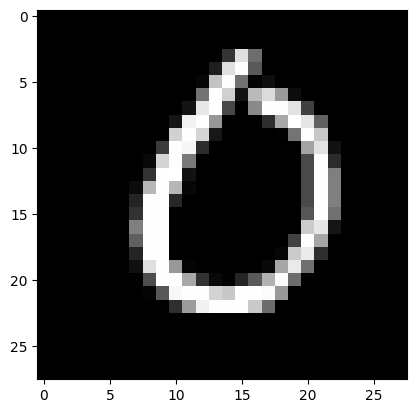

In [38]:
# reshape to show (remove channel dimension)
sample = sample.squeeze()
plt.imshow(sample, cmap="gray")

In [ ]:
import cv2
import numpy as np
import torch
import os
from typing import Union, Literal, List, Optional
from pathlib import Path


class ImageProcessingError(Exception):
    pass


def read_all_images_from_dir(
    img_dir: str,
    scaling: str,
    to_h: Optional[int],
    to_w: Optional[int],
) -> List[torch.Tensor]:
    SUPPORTED_EXTENSIONS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
    paths = [
        os.path.join(img_dir, f)
        for f in os.listdir(img_dir)
        if f.endswith(tuple(SUPPORTED_EXTENSIONS))
    ]
    imgs = [
        parse_image_to_tensor(image_path=p, scaling=scaling, to_h=to_h, to_w=to_w)
        for p in paths[0:3]
    ]
    return imgs


def normalize_image(
    image: np.ndarray, method: Literal["STANDARD", "MINMAX", "ROBUST", "NONE"]
) -> np.ndarray:
    """
    Normalize image data using specified method with cv2.

    Args:
        image (np.ndarray): Input image array of shape (C, H, W)
        method (Literal["STANDARD", "MINMAX", "ROBUST", "NONE"]): Normalization method

    Returns:
        np.ndarray: Normalized image array

    Raises:
        ImageProcessingError: If normalization fails
    """
    try:
        if method == "NONE":
            return image

        if method == "MINMAX":
            # Scale to [0,1] range
            return cv2.normalize(
                image,
                None,
                alpha=0,
                beta=1,
                norm_type=cv2.NORM_MINMAX,
                dtype=cv2.CV_32F,
            )

        elif method == "STANDARD":
            # Standardize to zero mean and unit variance
            mean = np.mean(image, axis=(1, 2), keepdims=True)
            std = np.std(image, axis=(1, 2), keepdims=True)
            return (image - mean) / (
                std + 1e-8
            )  # add epsilon to prevent division by zero

        elif method == "ROBUST":
            # Use median and IQR instead of mean/std for robustness to outliers
            median = np.median(image, axis=(1, 2), keepdims=True)
            q75, q25 = np.percentile(image, [75, 25], axis=(1, 2), keepdims=True)
            iqr = q75 - q25
            return (image - median) / (iqr + 1e-8)

        else:
            raise ValueError(f"Unsupported normalization method: {method}")

    except Exception as e:
        raise ValueError(f"Failed to normalize image: {str(e)}")


def parse_image_to_tensor(
    image_path: Union[str, Path],
    scaling: str,
    to_h: Optional[int] = None,
    to_w: Optional[int] = None,
) -> torch.Tensor:
    """
    Parses an image from a given path to a PyTorch tensor.

    This function performs the following operations:
    1. Reads an image from the specified path
    2. Resizes it to the specified dimensions
    3. Converts it to grayscale if it's a color image
    4. Transposes the dimensions to (C, H, W)
    5. Normalizes the pixel values using the specified method
    6. Converts it to a PyTorch tensor

    Args:
        image_path (Union[str, Path]): Path to the image file
        config (DefaultConfig): Configuration object with image processing settings

    Returns:
        torch.Tensor: Processed image tensor with shape (C, H, W)

    Raises:
        ImageProcessingError: If there are issues with image format, shape, or processing
        FileNotFoundError: If the image file doesn't exist
        ValueError: If input dimensions are invalid
    """
    # INPUT VALIDATION ----------------------------------------------
    if not validate_image_path(image_path):
        raise FileNotFoundError(f"Invalid image path: {image_path}")
    image_path = Path(image_path)
    SUPPORTED_EXTENSIONS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
    if image_path.suffix.lower() not in SUPPORTED_EXTENSIONS:
        raise ImageProcessingError(
            f"Unsupported image format: {image_path.suffix}. "
            f"Supported formats are: {', '.join(SUPPORTED_EXTENSIONS)}"
        )
    # IMAGE PROCESSING ----------------------------------------------
    try:
        # Read image based on format
        if image_path.suffix.lower() in {".tif", ".tiff"}:
            image = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
        else:
            image = cv2.imread(str(image_path))

        if image is None:
            raise FileNotFoundError(f"Failed to read image: {image_path}")

        (h, w, _) = image.shape[:3]
        if to_h is None:
            to_h = h
        if to_w is None:
            to_w = w

        if not (2 <= len(image.shape) <= 3):
            raise ImageProcessingError(
                f"Image has unsupported shape: {image.shape}. "
                "Supported shapes are 2D and 3D."
            )

        print(f"imgage shape after transpose{image.shape}")
        try:
            image = cv2.resize(image, (to_w, to_h), interpolation=cv2.INTER_AREA)
            print(f"imgage shape after resize{image.shape}")
        except Exception as e:
            raise ImageProcessingError(f"Failed to resize image: {str(e)}")

        image = normalize_image(image=image, method=scaling)

        print(f"imgage shape after normalize{image.shape}")
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # check if format is (C, H, W)
        if len(image.shape) == 2:
            # add channel dimension
            image = np.expand_dims(image, axis=2)
            print(f"shape after np.expand_dims: {image.shape}")

        image = image.transpose(2, 0, 1)
        print(f"shape after transpose: {image.shape}")
        return image

    except Exception as e:
        if isinstance(e, (FileNotFoundError, ImageProcessingError, ValueError)):
            raise
        raise ImageProcessingError(
            f"Unexpected error during image processing: {str(e)}"
        )


def validate_image_path(image_path: Union[str, Path]) -> bool:
    """
    Validates if the given image path exists and has a supported format.

    Args:
        image_path (Union[str, Path]): Path to validate

    Returns:
        bool: True if path is valid, False otherwise
    """

    path = Path(image_path) if isinstance(image_path, str) else image_path
    return (
        path.exists()
        and path.is_file()
        and path.suffix.lower() in {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
    )


## 05 How to add a new architecture
### High level workflow
To add a new autoencoder architecture, you need to at least code two things:
- the model architecture itself in  `src/autoencodix/modeling/` - anlogous to `_varix_architecture.py`
- the pipeline itself in `src/autoencodix/` - analgous to `varix.py`
Depending on the complexity and data requirements you might also want to provide the following:
- a new custom dataset class in `src/autoencodix/data` - analogous to `numeric_dataset.py`
- a new custom preprocessor in `src/autoencodix/data` - as in `preprocessor.py`
- a new custom trainer in `src/autoencodix/trainers` - as in `_general_trainer.py`
  - including a custom predict method of your trainer
- a custom loss for your model
- a custom visualizer (no example implemented yet)
- a custom evaluator for downstream tasks (no example implemented yet)
- a custom tuner (not sure if this will be part of the package)
### High level structure
- Each autoencodix model in our family is based on our base classes in `src/autoencodix/base`. Here we have (often abstract) classes that define the general structure of each step (preprocess, fit, predict, evaluate, visualize) in our pipeline, as well as additional classes e.g. losses.
- In these base classes we've implemented shared functionalities, like calling the corresponding trainer, or preprocessor.
- The base classes also guide you to the structure of your new class. The methods of the base classes should not be changed. Rather overwrite the method in the implementation of your child class in case you need to make changes.

### Must-do files details
We'll illustrate this by an example. We want to add the new architecture with the name MySpecial to our package. First we add the actual architecture:
- create the file `src/autoencodix/modeling/_myspecialix_architecture.py` (note files that should not be imported at end-user lever have a leading underscore).
- create the file `tests/test_modelling/test_myspecialix_architecture`
- we write the class itself that might look like:
```python
from autoencodix.base._base_autoencoder import BaseAutoencoder
# your imports
# TODO


# needs to inherit from BaseAutoencoder
class MySpecialArchitecture(BaseAutoencoder):
    """
    MySpecial implementation accroding to (cite paper, yourself, etc)

    Attributes
    ----------
    self.input_dim : int
        number of input features
    self.config: DefaultConfig
        Configuration object containing model architecture parameters
    self._encoder: nn.Module
        Encoder network of the autoencoder
    self._decoder: nn.Module
        Decoder network of the autoencoder

    Methods
    -------
    my_super_special_method():
        does cool stuff
    _build_network()
        Construct the encoder and decoder networks via the LayerFactory
    encode(x: torch.Tensor) -> torch.Tensor
        Encode the input tensor x
    decode(x: torch.Tensor) -> torch.Tensor
        Decode the latent tensor x
    forward(x: torch.Tensor) -> ModelOutput
        Forward pass of the model, fills in the reconstruction and latentspace attributes of ModelOutput class.

    """

    def __init__(
        self, config: Optional[Union[None, DefaultConfig]], input_dim: int
    ) -> None:
        if config is None:
            config = DefaultConfig()
        self._config = config
        super().__init__(config, input_dim)
        self.input_dim = input_dim # we always base the input dimension (usually number of features in your dataset)

        # populate self.encoder and self.decoder
        self._build_network()

    def _build_network(self) -> None:
        """
        Construct the encoder and decoder networks.
        See your _layer_factory.py file that could help you here.
        Also check other implementation to see how to use _layer_factory.py
        """
        self._encoder = TODO
        self._decoder = TODO


    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode the input tensor x

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        torch.Tensor
            Encoded tensor

        """
        encoded = self._encoder(x)
        return encoded


    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Decode the latent tensor x

        Parameters
        ----------
        x : torch.Tensor
            Latent tensor

        Returns
        -------
        torch.Tensor
            Decoded tensor

        """
        return self._decoder(x)

    def forward(self, x: torch.Tensor) -> ModelOutput:
        """
        Forward pass of the model, fill

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        ModelOutput
            ModelOutput object containing the reconstructed tensor and latent tensor

        """
        latent = self.encode(x)
        x_hat = self.decode(z)
        # fill model output arcodding to your needs (we need reconstruction and a latentspace, see ModelOuput class for required output)
        return ModelOutput(
            reconstruction=x_hat,
            latentspace=latent
            latent_mean=None,
            latent_logvar=None,
            additional_info=None,
        )

```
- adjust the `__init__.py` in `src/autoencodix/modelling` to import `MySpecialArchitecture
- next we write tests for the newly created file in the test file
- lastly, we need to create the pipeline file:
  - create `src/autoencodix/myspecialix.py`
  - create `tests/test_myspecialix.py`
- the `myspecialix.py` might look like this
```python
# your imports
# TODO

class MySpecialix(BasePipeline): # must inhertit from BasePipeline
    """
    MySpecialix specific version of the BasePipeline class.
    Inherits preprocess, fit, predict, evaluate, and visualize methods from BasePipeline.

    Attributes
    ----------
    data : Union[np.ndarray, AnnData, pd.DataFrame]
        Input data from the user
    config : Optional[Union[None, DefaultConfig]]
        Configuration object containing customizations for the pipeline
    _preprocessor : Preprocessor
        Preprocessor object to preprocess the input data (custom for Vanillix)
    _visualizer : Visualizer
        Visualizer object to visualize the model output (custom for Vanillix)
    _trainer : GeneralTrainer
        Trainer object that trains the model (custom for Vanillix)
    _evaluator : Evaluator
        Evaluator object that evaluates the model performance or downstream tasks (custom for Vanillix)
    result : Result
        Result object to store the pipeline results
    _datasets : Optional[DatasetContainer]
        Container for train, validation, and test datasets (preprocessed)
    data_splitter : DataSplitter
        DataSplitter object to split the data into train, validation, and test sets
    """

    def __init__(
        self,
        data: Union[np.ndarray, AnnData, pd.DataFrame],
        # this can be also a custom Type like MySpecialixDataset
        dataset_type: Type[BaseDataset] = NumericDataset,
        # This will be the Type MySpecialixArchitecture that we created before
        model_type: Type[BaseAutoencoder] = MySpecialixArchitecture,
        # This can be a custom Loss class, or an exisiting one see _losses.py
        loss_type: Type[BaseLoss] = VanillixLoss,
        preprocessor: Optional[Preprocessor] = None,
        visualizer: Optional[BaseVisualizer] = None,
        evaluator: Optional[Evaluator] = None,
        result: Optional[Result] = None,
        datasplitter_type: Type[DataSplitter] = DataSplitter,
        custom_splits: Optional[Dict[str, np.ndarray]] = None,
        config: Optional[DefaultConfig] = None,
    ) -> None:
        """Initialize MySpecialix pipeline with customizable components.

        Some components are passed as types rather than instances because they require
        data that is only available after preprocessing.

        Parameters
        ----------
        data : Union[np.ndarray, AnnData, pd.DataFrame]
            Input data to be processed
        trainer_type : Type[BaseTrainer]
            Type of trainer to be instantiated during fit step, default is GeneralTrainer
        dataset_type : Type[BaseDataset]
            Type of dataset to be instantiated post-preprocessing, default is NumericDataset
        loss_type : Type[BaseLoss], which loss to use for Vanillix, default is VanillaAutoencoderLoss
        preprocessor : Optional[Preprocessor]
            For data preprocessing, default creates new Preprocessor
        visualizer : Optional[Visualizer]
            For result visualization, default creates new Visualizer
        evaluator : Optional[Evaluator]
            For model evaluation, default creates new Evaluator
        result : Optional[Result]
            Container for pipeline results, default creates new Result
        datasplitter_type : Type[DataSplitter], optional
            Type of splitter to be instantiated during preprocessing, default is DataSplitter
        custom_splits : Optional[Dict[str, np.ndarray]]
            Custom train/valid/test split indices
        config : Optional[DefaultConfig]
            Configuration for all pipeline components
        """
        super().__init__(
            data=data,
            dataset_type=dataset_type,
            trainer_type=trainer_type,
            model_type=model_type,
            loss_type=loss_type,
            preprocessor=preprocessor or Preprocessor(),
            visualizer=visualizer or Visualizer(),
            evaluator=evaluator or Evaluator(),
            result=result or Result(),
            datasplitter_type=datasplitter_type,
            config=config or DefaultConfig(),
            custom_split=custom_splits,
        )

```
##### More explaination to the passing of Types instead of classes:
Most functionality of the pipeline comes from the BasePipeline. To make the methods custom to our specific architecture that we use in our `MySpecial` pipeline, we need to pass our specializes subclasses. Since we don't have all required parameters for this subclasses when calling the init method of the parent class, we pass only the type of the subclasses. These types need to be childs of the corresponding base class. Inside the BasePipeline we instantiate the specific classes with the required paramters as soon as we have them
### Optional files details
The optional files work from the same principle as the mandatory files, so we can always create a special class based on the baseclass and then we pass the type of our special class to our MySpecialix Pipeline e.g MySpecialTrainer n the init mehtod of MySpecialix (same as we did with MySpecialArchitecture)

# TODOS
- show how to update and work with the config object (later)

### SANDBOX 
testing Varix and losses, especially sub_losses in result_object

In [ ]:
# test readers

### Data preprocessing
Goal: 4 cases unserer alten Implemntation abbilden
- single cell (s. Beispiel Jan)
- image (tcga beispiel)
- multi TCGA omics (mini Beispiel)
- ontologie Beispiel

Hauptsächlich get es darum wie wir Daten und Metadaten von verschiedenen Omics Typen speichern und wie der Nutzer die Information über die Daten ans package weitergeben.
Im ersten Schritt der Sanbox werden wir nun versuchen jeden case in einem AnnData Objekt abzubilden und dann auf Grundlage des AnnData Objekts das perprocessing machen.

### Updated config structure

#### Generate from object
Alternatively, we can just create our DefaultConfig Object and initialize it with the data info

#### Second Single Cell

In [ ]:
config = DefaultConfig.model_validate(yaml.safe_load(Path("scconfig.yaml").read_text()))

### XModalix with images

#### images and bulk-seq

In [ ]:
# TODO: add the rest of the code
img_folder = "images/tcga_mini"
xmodal_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "RNA": DataInfo(
                file_path=os.path.join(root_dir, mrna_file),
                data_type=DataType.NUMERIC,
            ),
            "IMG": DataInfo(
                file_path=os.path.join(root_dir, "tcga_mappings.txt"),
                data_type=DataType.IMG,
                img_root=os.path.join(root_dir, img_folder),
            ),
            "CLINICAL": DataInfo(
                file_path=os.path.join(root_dir, clin_file),
                data_type=DataType.ANNOTATION,
            ),
        }
    )
)


In [81]:
# bulk seq standard
common_samples, config_filled = load_and_intersect_bulkdata(config=xmodal_config)
print(len(common_samples))
adata = build_bulk_anndata(config=config_filled, common_samples=common_samples)

Loading RNA data from data/raw/data_mrna_seq_v2_rsem_formatted.parquet
Loading IMG data from data/raw/tcga_mappings.txt
Skipping image data
Loading CLINICAL data from data/raw/data_clinical_formatted.parquet
10059
Skipping image data


In [82]:
print(adata)

AnnData object with n_obs × n_vars = 10059 × 16313
    obs: 'PATIENT_ID', 'ONCOTREE_CODE', 'CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'TUMOR_TYPE', 'GRADE', 'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_SOURCE_SITE_CODE', 'TUMOR_TISSUE_SITE', 'ANEUPLOIDY_SCORE', 'SAMPLE_TYPE', 'MSI_SCORE_MANTIS', 'MSI_SENSOR_SCORE', 'SOMATIC_STATUS', 'TMB_NONSYNONYMOUS', 'TISSUE_SOURCE_SITE', 'SUBTYPE', 'CANCER_TYPE_ACRONYM', 'OTHER_PATIENT_ID', 'AGE', 'SEX', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'AJCC_STAGING_EDITION', 'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH', 'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 'ETHNICITY', 'FORM_COMPLETION_DATE', 'HISTORY_NEOADJUVANT_TRTYN', 'ICD_10', 'ICD_O_3_HISTOLOGY', 'ICD_O_3_SITE', 'INFORMED_CONSENT_VERIFIED', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_T_STAGE', 'PERSON_NEOPLASM_CANCER_STATUS', 'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', 'PRIOR_DX', 'RACE', 'RADIATION_THERAPY', 'WEIGHT', 'IN_PANCAN

In [90]:
print(scadata)

AnnData object with n_obs × n_vars = 45549 × 19475
    obs: 'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_joint_wnn_umap', 'X_umap'
    layers: 'RNA'


In [ ]:
def read_img(file_path):
    ext = file_path.split(".")[-1]
    if not ext in ["png", "jpg", "jpeg"]:
        raise ValueError(f"Unsupported image format: {ext}")
    img = cv2.imread(file_path)
    # read image
    return img

In [ ]:
for k, v in xmodal_config.data_config.data_info.items():
    if v.data_type == DataType.IMG:
        print(f"Image folder: {v.file_path}")

Image folder: data/raw/images/tcga_mini


In [ ]:
from typing import List


class XModaleData:
    mapping_file: str
    img_folder: str
    _img_array: List[np.ndarray]
    _labels: Dict[str, List[Union[str, int, float]]]

In [ ]:
from collections import defaultdict
import cv2

adata = ad.AnnData()
data_dict = defaultdict(dict)
adata = ad.AnnData(
    X=config.data_config.data_info["RNA"].data_object.loc[list(common_samples)].values,
    obs=pd.DataFrame(index=list(common_samples)),
)


previous = {}
for k, v in config.data_config.data_info.items():
    if v.data_type == DataType.IMG:
        img_folder = v.img_root
        mappings = pd.read_csv(v.file_path, sep="\t")
        file_paths = list(mappings["img_path"].values)
        imgs = [read_img(os.path.join(img_folder, img)) for img in file_paths]
        config.data_config.data_info[k].data_object = {
            "imgs": imgs,
            "mappings": mappings,
        }
    if v.data_type == DataType.ANNOTATION:
        ann_df = pd.read_parquet(os.path.join(v.file_path))
        adata.obs = ann_df

### Next TODOS

- write docu of new data handling:
  - how to fill config
  - how different scenarios work
  - how to proceed

#### old testing stuff

In [2]:
sub_losses = result.sub_losses

In [2]:
from autoencodix.utils._result import Result, LossRegistry
from autoencodix.utils.default_config import DefaultConfig
from autoencodix.utils._traindynamics import TrainingDynamics

In [ ]:
empty_result = Result()
sample_model = None
sample_datasets = {"train": None, "valid": None, "test": None}
sample_recon_data = {
    0: {"train": 0.0, "valid": 0.0, "test": 0.0},
    100: {"train": 0.0, "valid": 0.0, "test": 0.0},
}
sample_var_loss_data = {
    0: {"train": 0.0, "valid": 0.0, "test": 0.0},
    2: {"train": 0.0, "valid": 0.0, "test": 0.0},
    100: {"train": 0.0, "valid": 0.0, "test": 0.0},
}
sample_recon_data_dyn = TrainingDynamics(_data=sample_recon_data)
sample_var_loss_data_dyn = TrainingDynamics(_data=sample_var_loss_data)
sample_losses = LossRegistry(
    _losses={"recon_loss": sample_recon_data_dyn, "var_loss": sample_var_loss_data_dyn}
)
filled_result = Result(
    model=sample_model, datasets=sample_datasets, sub_losses=sample_losses
)

recon_loss_data1 = {
    0: {"valid": 0.1, "train": 0.2, "test": 0.3},
    1: {"valid": 0.4, "train": 0.5, "test": 0.6},
    2: {"valid": 0.7, "train": 0.8, "test": 0.9},
}
var_loss_data1 = {
    0: {"valid": 0.11, "train": 0.21, "test": 0.31},
    1: {"valid": 0.31, "train": 0.41, "test": 0.51},
    2: {"valid": 0.51, "train": 0.61, "test": 0.71},
}

recon_dynamics1 = TrainingDynamics(_data=recon_loss_data1)
var_dynamics1 = TrainingDynamics(_data=var_loss_data1)
sample_registry = LossRegistry(
    _losses={"recon_loss": recon_dynamics1, "var_loss": var_dynamics1}
)
sample_result1 = Result(sub_losses=sample_registry)
recon_loss_data2 = {
    0: {"valid": 0.15, "train": 0.25},
    1: {"valid": 0.45, "train": 0.55, "test": None},
    2: {"valid": None, "train": 0.85, "test": 0.95},
}
var_loss_data2 = {
    0: {"valid": 0.16, "train": 0.26, "test": 0.36},
    1: {"valid": 0.36, "train": 0.46},
    2: None,
}  # should not be updated

recon_dynamics2 = TrainingDynamics(_data=recon_loss_data2)
var_dynamics2 = TrainingDynamics(_data=var_loss_data2)
sample_registry2 = LossRegistry(
    _losses={"recon_loss": recon_dynamics2, "var_loss": var_dynamics2}
)
sample_result2 = Result(sub_losses=sample_registry2)

In [16]:
to_update = {
    0: {"train": 0.0, "valid": 0.0, "test": 0.0},  # totally overwrite
    2: {"train": 0.0, "valid": 0.0, "test": 0.0},  # keep all
    3: {},  # update with partial data
    4: None,  # udate with all
    5: {
        "train": None,
        "valid": 0.0,
        "test": 0.0,
    },  # update with partial data (keep test)
    6: {"train": 0.0},  # update with partial data (keep train), add vlaid and test
    7: {"train": 0},  # update with partial data {train: 0.1}
    100: {"train": 0.0, "valid": 0.0, "test": 0.0},  # not in to update
}

update_with = {
    0: {"train": 0.1, "valid": 0.2, "test": 0.3},
    1: {"train": 0.4, "valid": 0.5, "test": 0.6},
    2: {},
    3: {"train": 0.7, "valid": 0.8},
    4: {"train": 0.9, "valid": 1.0, "test": 1.1},
    5: {"train": 0.12, "valid": 0.22},
    6: {"valid": 0.32, "test": 0.42},
    7: {"train": 0.1},
}

expected_result = {
    0: {"train": np.array(0.1), "valid": np.array(0.2), "test": np.array(0.3)},
    1: {"train": np.array(0.4), "valid": np.array(0.5), "test": np.array(0.6)},
    2: {"train": np.array(0.0), "valid": np.array(0.0), "test": np.array(0.0)},
    3: {"train": np.array(0.7), "valid": np.array(0.8)},
    4: {"train": np.array(0.9), "valid": np.array(1.0), "test": np.array(1.1)},
    5: {"train": np.array(0.12), "valid": np.array(0.22), "test": np.array(0.0)},
    6: {"train": np.array(0.0), "valid": np.array(0.32), "test": np.array(0.42)},
    7: {"train": np.array(0.1)},
    100: {"train": np.array(0.0), "valid": np.array(0.0), "test": np.array(0.0)},
}

to_update_dyn = TrainingDynamics(_data=to_update)
to_update_registry = LossRegistry(
    _losses={
        "recon_loss": to_update_dyn,
        "var_loss": to_update_dyn,
        "more_loss": TrainingDynamics(_data={}),
    }
)
to_update_result = Result(sub_losses=to_update_registry)


update_with_dyn = TrainingDynamics(_data=update_with)
update_with_registry = LossRegistry(
    _losses={
        "recon_loss": update_with_dyn,
        "var_loss": TrainingDynamics(_data={}),
        "other_loss": TrainingDynamics(_data={}),
    }
)
update_with_result = Result(sub_losses=update_with_registry)
to_update_result.update(update_with_result)
after_update = dict(
    sorted(to_update_result.sub_losses.get(key="recon_loss").get().items())
)
expected_recon_dyn = TrainingDynamics(_data=expected_result)
expected_varloss_dyn = TrainingDynamics(_data=to_update)
expected_moreloss_dyn = TrainingDynamics(_data={})
expected_other_dyn = TrainingDynamics(_data={})
expected_loss_registry = LossRegistry(
    _losses={
        "recon_loss": expected_recon_dyn,
        "var_loss": expected_varloss_dyn,
        "more_loss": expected_moreloss_dyn,
        "other_loss": expected_other_dyn,
    }
)
expected_result = Result(sub_losses=expected_loss_registry)


In [ ]:
to_update_result.sub_losses._losses
for lossname, dynamics in expected_result.sub_losses.losses():
    print(lossname)
    print(type(dynamics._data))

recon_loss
<class 'dict'>
var_loss
<class 'dict'>
more_loss
<class 'dict'>
other_loss
<class 'dict'>


In [21]:
for lossname, dynamics in to_update_result.sub_losses.losses():
    print(lossname)
    print(dynamics.get())

recon_loss
{0: {'train': array(0.1), 'valid': array(0.2), 'test': array(0.3)}, 1: {'train': array(0.4), 'valid': array(0.5), 'test': array(0.6)}, 2: {'train': array(0.), 'valid': array(0.), 'test': array(0.)}, 3: {'valid': array(0.8), 'train': array(0.7)}, 4: {'valid': array(1.), 'test': array(1.1), 'train': array(0.9)}, 5: {'valid': array(0.22), 'test': array(0.), 'train': array(0.12)}, 6: {'train': array(0.), 'valid': array(0.32), 'test': array(0.42)}, 7: {'train': array(0.1)}, 100: {'train': array(0.), 'valid': array(0.), 'test': array(0.)}}
var_loss
{0: {'train': array(0.), 'valid': array(0.), 'test': array(0.)}, 2: {'train': array(0.), 'valid': array(0.), 'test': array(0.)}, 5: {'valid': array(0.), 'test': array(0.)}, 6: {'train': array(0.)}, 7: {'train': array(0)}, 100: {'train': array(0.), 'valid': array(0.), 'test': array(0.)}}
more_loss
{}
other_loss
{}


In [22]:
for lossname, dynamics in expected_result.sub_losses.losses():
    print(lossname)
    print(dynamics.get())

recon_loss
{0: {'train': array(0.1), 'valid': array(0.2), 'test': array(0.3)}, 1: {'train': array(0.4), 'valid': array(0.5), 'test': array(0.6)}, 2: {'train': array(0.), 'valid': array(0.), 'test': array(0.)}, 3: {'train': array(0.7), 'valid': array(0.8)}, 4: {'train': array(0.9), 'valid': array(1.), 'test': array(1.1)}, 5: {'train': array(0.12), 'valid': array(0.22), 'test': array(0.)}, 6: {'train': array(0.), 'valid': array(0.32), 'test': array(0.42)}, 7: {'train': array(0.1)}, 100: {'train': array(0.), 'valid': array(0.), 'test': array(0.)}}
var_loss
{0: {'train': 0.0, 'valid': 0.0, 'test': 0.0}, 2: {'train': 0.0, 'valid': 0.0, 'test': 0.0}, 3: {}, 4: None, 5: {'train': None, 'valid': 0.0, 'test': 0.0}, 6: {'train': 0.0}, 7: {'train': 0}, 100: {'train': 0.0, 'valid': 0.0, 'test': 0.0}}
more_loss
{}
other_loss
{}


In [ ]:
(filled_result.sub_losses._losses["var_loss"].get())

{0: {'train': array(0.26), 'valid': array(0.16), 'test': array(0.36)},
 2: {'train': 0.0, 'valid': 0.0, 'test': 0.0},
 100: {'train': 0.0, 'valid': 0.0, 'test': 0.0},
 1: {'valid': array(0.36), 'train': array(0.46)}}

In [16]:
# empty does not overwrite anything
result.update(empty_result)
result.losses.get()
result.datasets

DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x15ff96b30>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x15ff96bc0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x15ff96e00>)

In [10]:
# case one update empty result
# with: - empty result, - sample result1, - sample result2
empty_result.update(other=sample_result1)
empty_result.sub_losses._losses["recon_loss"].get()


{0: {'valid': array(0.1), 'train': array(0.2), 'test': array(0.3)},
 1: {'valid': array(0.4), 'train': array(0.5), 'test': array(0.6)},
 2: {'valid': array(0.7), 'train': array(0.8), 'test': array(0.9)}}

In [6]:
empty_result.update(other=sample_result2)

In [7]:
# case two update filled result
# with: - filled result, - sample result1, - sample result2, empty result
filled_result.update(other=sample_result1)

In [6]:
sub_losses == updated_losses

True

In [5]:
updated_losses = result.sub_losses
print(updated_losses)

LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics()})


In [9]:
for name, loss in updated_losses.losses():
    print(f"{name}: {loss}")
    print(loss.get())

recon_loss: TrainingDynamics()
{0: {'train': array(0.44560597), 'valid': array(0.24305786)}, 1: {'train': array(0.40050308), 'valid': array(0.23968849)}, 2: {'train': array(0.39850321), 'valid': array(0.2438124)}}
var_loss: TrainingDynamics()
{0: {'train': array(0.03078574), 'valid': array(0.00519827)}, 1: {'train': array(0.02884311), 'valid': array(0.00536202)}, 2: {'train': array(0.02645038), 'valid': array(0.00561051)}}


In [4]:
varix._trainer._model

_FabricModule(
  (_forward_module): VarixArchitecture(
    (_encoder): Sequential(
      (0): Linear(in_features=10, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=16, out_features=16, bias=True)
    )
    (_decoder): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplac

In [5]:
DefaultConfig().print_schema()


DefaultConfig Configuration Parameters:
--------------------------------------------------

latent_dim:
  Type: <class 'int'>
  Default: 16
  Description: Dimension of the latent space

n_layers:
  Type: <class 'int'>
  Default: 3
  Description: Number of layers in encoder/decoder

enc_factor:
  Type: <class 'int'>
  Default: 4
  Description: Scaling factor for encoder dimensions

input_dim:
  Type: <class 'int'>
  Default: 10000
  Description: Input dimension

drop_p:
  Type: <class 'float'>
  Default: 0.1
  Description: Dropout probability

learning_rate:
  Type: <class 'float'>
  Default: 0.001
  Description: Learning rate for optimization

batch_size:
  Type: <class 'int'>
  Default: 32
  Description: Number of samples per batch

epochs:
  Type: <class 'int'>
  Default: 3
  Description: Number of training epochs

weight_decay:
  Type: <class 'float'>
  Default: 0.01
  Description: L2 regularization factor

reconstruction_loss:
  Type: typing.Literal['mse', 'bce']
  Default: mse
  

In [6]:
config = DefaultConfig()
config.n_layers

3

### Check model architecture layers

varix.

In [8]:
varix._trainer._model

_FabricModule(
  (_forward_module): VarixArchitecture(
    (_encoder): Sequential(
      (0): Linear(in_features=10, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=16, out_features=16, bias=True)
    )
    (_decoder): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplac

In [9]:
config = DefaultConfig()
config.n_layers

3

In [ ]:
from autoencodix.trainers._general_trainer import GeneralTrainer
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig
import numpy as np

sample_data = np.random.rand(10, 100)

varix = acx.Varix(
    data=sample_data,
    config=DefaultConfig(n_layers=3, epochs=1, enc_factor=2, latent_dim=2),
)
varix.preprocess()
varix.fit()
print(varix._trainer._model)
for enc_factor in [1, 2, 3]:
    print(f"ENCODER FACTOR: {enc_factor}")
    varix = acx.Varix(
        data=sample_data,
        config=DefaultConfig(n_layers=2, epochs=1, enc_factor=enc_factor),
    )
    varix.preprocess()
    varix.fit()
    print(varix._trainer._model)

cpu not relevant here
[100, 50, 25, 12, 2]
Epoch: 0, Loss: 0.5027862191200256
_FabricModule(
  (_forward_module): VarixArchitecture(
    (_mu): Linear(in_features=12, out_features=2, bias=True)
    (_logvar): Linear(in_features=12, out_features=2, bias=True)
    (_encoder): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=25, bias=True)
      (5): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=25, out_features=12, bias=True)
      (9): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.1, inplace=False)
      (11): ReLU()
    )
    (_decoder): Sequential(
      (0): Linear(in_features=2, out_fea

In [13]:
len(varix._trainer._model._decoder)

1

In [ ]:
import torch.nn as nn

empty = nn.Sequential()

In [16]:
len(empty)

0

In [4]:
van = acx.Vanillix(data=sample_data, config=DefaultConfig(n_layers=0, epochs=1))
van.preprocess()
van.fit()
print(van._trainer._model)

cpu not relevant here


Epoch: 0, Loss: 0.5317338109016418
_FabricModule(
  (_forward_module): VanillixArchitecture(
    (_encoder): Sequential(
      (0): Linear(in_features=100, out_features=16, bias=True)
    )
    (_decoder): Sequential(
      (0): Linear(in_features=16, out_features=100, bias=True)
    )
  )
  (_original_module): VanillixArchitecture(
    (_encoder): Sequential(
      (0): Linear(in_features=100, out_features=16, bias=True)
    )
    (_decoder): Sequential(
      (0): Linear(in_features=16, out_features=100, bias=True)
    )
  )
)
